#Link To Paper
https://drive.google.com/file/d/1xbtyMn73fR8bx6IMe0sXpVuPo88Gy5PS/view?usp=sharing

Please glance through to understand the code

# Setup

In [ ]:
%%capture
!pip install wordcloud
!pip install tensorflow_text
!pip install rake-nltk
!pip install keras-tuner

In [ ]:
import os
import re
import string
import random
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import inflect
import tensorflow_text
import tensorflow.keras.backend as K
import kerastuner as kt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.utils import vis_utils
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Embedding, TimeDistributed, Layer, GlobalAveragePooling1D, Flatten, Multiply
from keras.layers import Lambda, RepeatVector, Bidirectional, MultiHeadAttention, LayerNormalization, Dropout, Reshape, Concatenate
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk import ngrams
from rake_nltk import Rake
from google.colab import files
from wordcloud import WordCloud, STOPWORDS
from IPython.display import SVG
from tensorflow.keras.losses import sparse_categorical_crossentropy
#nltk.download('words')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from ipykernel import kernelapp as app


In [ ]:
################################### LOAD FILES ################################
jokes = np.load("encoded_jokes.npy", allow_pickle=True)

# Create tokenizer from saved vocab file
tokenizer = tensorflow_text.BertTokenizer('vocab.txt', **dict(lower_case=True))

# Tokenize jokes
tokenized_jokes = tokenizer.detokenize(jokes)
tokenized_jokes = list(tokenized_jokes.numpy())
data = []

for x in tokenized_jokes:
  x = [y.decode("utf-8") for y in x]
  x = " ".join([y for y in x if y != '[PAD]'])
  data.append(x)


# Extract keywords
r = Rake(max_length=1)
keywords = []

for x in data:
  kw = r.extract_keywords_from_text(x)
  kw = r.get_ranked_phrases()
  keywords.append(kw)


# Tokenize and encode keywords
keywords_int = tf.ragged.constant(keywords)
keywords_int = tokenizer.tokenize(keywords_int)
# Reshape
keywords_int = keywords_int.merge_dims(-2,-1).to_list()

# Squeeze list
seq_in = []
for x in keywords_int:
  x = [item for sublist in x for item in sublist]
  seq_in.append(x)

# Pad sequences
seq_in = keras.preprocessing.sequence.pad_sequences(seq_in,
                                            value=0,
                                            padding='post',
                                            maxlen=30)

# Prepare the sequences
#seq_in = np.insert(seq_in[:,:-1], 0, 2, axis=1)
seq_out = jokes[:, :-1]
seq_out = np.insert(seq_out[:,:-1], 0, 2, axis=1)
seq_lab = np.expand_dims(seq_out[:, 1:],axis=2)
seq_lab = keras.preprocessing.sequence.pad_sequences(seq_lab,
                                            value=0,
                                            padding='post',
                                            maxlen=30)

# Hyper Parameters
batch_size = 128
vocab_size = 9832
maxlen = 30

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/ragged/ragged_tensor.py:2053: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(rows)


In [ ]:
# Get the required data
source = seq_out[1000:]
target = seq_out[1000:]
keywords = seq_in[1000:]
labels = seq_lab[1000:]

# Select test set.
test_seq = seq_out[:1000]
test_kw = seq_in[:1000]

# Utils

In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads, embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# Generator Callback
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_prompt, tokenizer, top_k=3, print_every=1
    ):
        start_tokens = tokenizer.tokenize(start_prompt)
        start_tokens = tf.squeeze(start_tokens,axis=0)
        start_tokens = list(tf.squeeze(start_tokens, axis=1).numpy())
        start_tokens = [_ for _ in start_tokens]

        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.print_every = print_every
        self.k = top_k
        self.tokenizer = tokenizer

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = list(np.asarray(indices).astype("int32"))
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        x = tokenizer.detokenize([[number]]).to_list()
        x = x[0][0].decode("utf-8")
        return x

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
            word_tokens = [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        txt = " ".join([x for x in word_tokens if x != '[PAD]'])
        print(f"generated text:\n{txt}\n")

In [ ]:
############################### TOP-K Sampling ##############################
def generate(model, max_tokens, start_prompt, tokenizer, top_k=3, print_every=1):
        # Tokenise prompt
        start_tokens = tokenizer.tokenize(start_prompt)
        start_tokens = tf.squeeze(start_tokens,axis=0)
        start_tokens = list(tf.squeeze(start_tokens, axis=1).numpy())
        start_tokens = [_ for _ in start_tokens]
        
        # Start generating
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = model.predict(x)

            logits = y[0][sample_index]
            logits, indices = tf.math.top_k(logits, k=top_k, sorted=True)
            indices = np.asarray(indices).astype("int32")

            # remove zero predictions
            #drop = np.where(indices == 0)
            #indices = indices[indices != 0]
            #logits = np.delete(logits.numpy(),drop)

            # Pass through softmax
            preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
            preds = np.asarray(preds).astype("float32")
            sample_token = np.random.choice(indices, p=preds)

            # Stop generating if end of sequence
            if sample_token == 0:
              break

            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
            #Detokenize
            word_tokens = tokenizer.detokenize([start_tokens]).to_list()
            #Decode
            word_tokens = [x.decode("utf-8") for x in word_tokens[0]]
            # Drop pads and convert to string
            txt = " ".join([x for x in word_tokens])
            txt = txt.replace(" ##", "")
        return txt


####################### TEST ################################
def test_model(model):
  samples = []
  samples.append("how do you end two deaf persons '")
  samples.append("What does a blonde have in common with a hurricane")
  samples.append("I went to a white pride parade the other day")
  samples.append("i would  make a joke about my neighbor")
  samples.append("what is the difference between god and you")

  # Check if model prints the correct sentence, given first 7 tokens
  for i in range(len(samples)):
    sample = generate(model, maxlen, samples[i], tokenizer)
    #print("TRUE: ", s[i])
    print("INPUT: ", samples[i])
    print("GENERATED: ",sample)
    print("")

In [ ]:
###################################### LUONG ATTENTION LAYER #############################
class LuongAttentionLayer(Layer):
  def compute_mask(self, inputs, mask=None):
    if mask == None:
      return None
    return mask[1]

  def compute_output_shape(self, input_shape):
    return (input_shape[1][0],input_shape[1][1],input_shape[1][2]*2)


  def call(self, inputs, mask=None):
    encoder_outputs, decoder_outputs = inputs

    # transpose the dimensions of decoder outputs
    decoder_outputs_t = K.permute_dimensions(decoder_outputs, (0,2,1))

    # calculate luong score
    luong_score = K.batch_dot(encoder_outputs,decoder_outputs_t)
    luong_score = K.softmax(luong_score, axis=1) # along the 2nd axis

    # expand the dimensions of luong score and encoded outputs to enable multiplication
    luong_score = K.expand_dims(luong_score, axis=-1) # along last axis
    encoder_outputs = K.expand_dims(encoder_outputs, axis=2) # along 2nd axis

    # get encoded vector
    encoder_vector = encoder_outputs * luong_score
    encoder_vector = K.sum(encoder_vector, axis=1, keepdims=False)

    # [batch,max_dec,2*emb]
    new_decoder_outputs = K.concatenate([decoder_outputs, encoder_vector])

    return new_decoder_outputs
    

In [ ]:
######################################## SAMPLING LAYER ####################################
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


#################################### VAE LOSS ##############################
def vae_loss(y_true, y_pred):
    xent_loss = sparse_categorical_crossentropy(y_true, y_pred)
    kl_loss =  -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    return xent_loss + kl_loss

In [ ]:
def decoder_decode(topic, start=[2]):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(topic)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the index of start token.
    for i in range(len(start)):
      target_seq[i, i] = start[i]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #sampled_token = reverse_target_word_index[sampled_token_index]
        sampled_token = tokenizer.detokenize([[sampled_token_index]]).to_list()
        sampled_token = sampled_token[0][0].decode("utf-8")

        if sampled_token != '[PAD]':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == '[PAD]' or len(decoded_sentence.split()) \
            >= maxlen - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence.replace(" ##",'')

# Load models
def load_model(model_filename, model_weights_filename):
    with open(model_filename, 'r', encoding='utf8') as f:
        model = keras.models.model_from_json(f.read())
    model.load_weights(model_weights_filename)
    return model

In [ ]:
def detokenize(indices):
  word_tokens = tokenizer.detokenize([indices]).to_list()
  word_tokens = [x.decode("utf-8") for x in word_tokens[0]]
  return word_tokens
  return " ".join([x for x in word_tokens if x != '[PAD]'])

# Joke-Seq2Seq

In [ ]:
###################################### LUONG ATTENTION LAYER #############################
class LuongAttentionLayer(layers.Layer):
  def compute_mask(self, inputs, mask=None):
    if mask == None:
      return None
    return mask[1]

  def compute_output_shape(self, input_shape):
    return (input_shape[1][0],input_shape[1][1],input_shape[1][2]*2)


  def call(self, inputs, mask=None):
    encoder_outputs, decoder_outputs = inputs

    # transpose the dimensions of decoder outputs
    decoder_outputs_t = K.permute_dimensions(decoder_outputs, (0,2,1))

    # calculate luong score
    luong_score = K.batch_dot(encoder_outputs,decoder_outputs_t)
    luong_score = K.softmax(luong_score, axis=1) # along the 2nd axis

    # expand the dimensions of luong score and encoded outputs to enable multiplication
    luong_score = K.expand_dims(luong_score, axis=-1) # along last axis
    encoder_outputs = K.expand_dims(encoder_outputs, axis=2) # along 2nd axis

    # get encoded vector
    encoder_vector = encoder_outputs * luong_score
    encoder_vector = K.sum(encoder_vector, axis=1, keepdims=False)

    # [batch,max_dec,2*emb]
    new_decoder_outputs = K.concatenate([decoder_outputs, encoder_vector])

    return new_decoder_outputs

######################################## SAMPLING LAYER ####################################
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Hyperparams
latent_dim = 100
embedding_dim = 200

#################################### ENCODER ##################################
# Encoder inputs
encoder_inputs = keras.Input(shape=(maxlen, ))

# Embedding layer
enc_emb = layers.Embedding(vocab_size, latent_dim, input_length=maxlen)(encoder_inputs)

# Sentence Average
enc_avg = layers.GlobalAveragePooling1D()(enc_emb)

# Hidden Dense
hidden_dense = layers.Dense(latent_dim)
hidden = hidden_dense(enc_avg)

# Encoder dense
enc_dense = layers.Dense(latent_dim)
encoder_outputs = enc_dense(enc_emb)


#################################### DECODER ####################################
# Decoder inputs
decoder_inputs = keras.Input(shape=(maxlen, ))

# Decoder embedding layer
dec_emb_layer = layers.Embedding(vocab_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = layers.LSTM(latent_dim, 
                    return_sequences=True,
                    return_state=True, 
                    dropout=0.4,
                    recurrent_dropout=0.0)

(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, 
                                                           initial_state=[hidden, hidden])

# Add Luong attention
attention = LuongAttentionLayer()
decoder_outputs = attention([encoder_outputs,decoder_outputs])

# Dense layer
decoder_dense = layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)


#################################### VAE MODEL ##############################
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 30, 100)      983200      input_9[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
global_average_pooling1d_4 (Glo (None, 100)          0           embedding_8[0][0]                
____________________________________________________________________________________________

In [ ]:
def model_builder(hp):
  ########## HYPERPARAMS ###########
  latent_dim = hp.Int('latent_dim', min_value=50, max_value=300, step=10)
  embedding_dim = hp.Int('embedding_dim', min_value=50, max_value=300, step=10)
  dropout = hp.Float('dropout', min_value=0.2, max_value=0.8, step=0.05)
  hp_learning_rate = hp.Float('learning_rate', min_value=0.001, max_value=0.02, step=0.001)

  ######### ENCODER #############
  encoder_inputs = keras.Input(shape=(30, ))
  enc_emb = layers.Embedding(9832, embedding_dim, input_length=30)(encoder_inputs)
  encoder_outputs = layers.GlobalAveragePooling1D()(enc_emb)
  encoder_outputs = layers.Dense(latent_dim)(encoder_outputs)

  ######### DECODER #############
  decoder_inputs = keras.Input(shape=(30, ))
  dec_emb_layer = layers.Embedding(9832, latent_dim, trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  decoder_lstm = layers.LSTM(latent_dim, 
                    return_sequences=True,
                    return_state=True, 
                    dropout=dropout,
                    recurrent_dropout=0.0)

  (decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, 
                                                           initial_state=[encoder_outputs, encoder_outputs])

  repeat = layers.RepeatVector(30)
  encoder_output_repeated = repeat(encoder_outputs)
  attention = LuongAttentionLayer()
  decoder_outputs = attention([encoder_output_repeated,decoder_outputs])
  decoder_dense = layers.TimeDistributed(layers.Dense(9832, activation='softmax'))
  decoder_outputs = decoder_dense(decoder_outputs)

  ########### VAE #############
  model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy())

  return model

In [ ]:
# Hyperparameter tuning
tuner = kt.Hyperband(
    model_builder,
    objective='val_loss',
    max_epochs=30,
    directory='hyperparams',
    hyperband_iterations=2)

tuner.search([seq_in,seq_out], seq_lab, epochs=10, validation_split=0.1, batch_size=batch_size)
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best Hyperparameters')
print(best_hps)

Trial 179 Complete [00h 16m 57s]
val_loss: 2.426854372024536

Best val_loss So Far: 2.304979085922241
Total elapsed time: 16h 47m 52s
INFO:tensorflow:Oracle triggered exit
Best Hyperparameters


In [ ]:
# Select best model
model = tuner.hypermodel.build(best_hps)
#model.save('seq2seq.h5')
with open('model.json', 'w', encoding='utf8') as f:
    f.write(model.to_json())
model.save_weights('model_weights.h5')
model.summary()

In [ ]:
# Hyperparams
epochs = 10
lr = 0.01
optimizer = keras.optimizers.Adam(learning_rate=lr)
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the best model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')
history = model.fit([keywords, target],
       labels,
       batch_size=batch_size,
       epochs=epochs,
       validation_split=0.1,
       callbacks=[es])

Epoch 1/10
709/709 [==============================] - 36s 49ms/step - loss: 3.2983 - val_loss: 2.6924
Epoch 2/10
709/709 [==============================] - 34s 48ms/step - loss: 2.5450 - val_loss: 2.4878
Epoch 3/10
709/709 [==============================] - 35s 50ms/step - loss: 2.3433 - val_loss: 2.4203
Epoch 4/10
709/709 [==============================] - 34s 48ms/step - loss: 2.2342 - val_loss: 2.3950
Epoch 5/10
709/709 [==============================] - 35s 49ms/step - loss: 2.1622 - val_loss: 2.3844
Epoch 6/10
709/709 [==============================] - 34s 48ms/step - loss: 2.1113 - val_loss: 2.3832
Epoch 7/10
709/709 [==============================] - 34s 48ms/step - loss: 2.0730 - val_loss: 2.3883
Epoch 8/10
709/709 [==============================] - 34s 48ms/step - loss: 2.0409 - val_loss: 2.3832
Epoch 9/10
709/709 [==============================] - 35s 49ms/step - loss: 2.0156 - val_loss: 2.3744
Epoch 10/10
709/709 [==============================] - 34s 49ms/step - loss: 1.994

In [ ]:
model.save_weights('seq2seq_weights.h5')

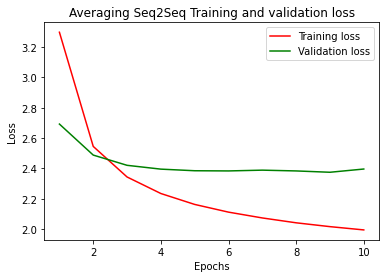

In [ ]:
# Plot History
history_dict = history.history
plt.plot(range(1,epochs+1), history_dict['loss'], 'r', label='Training loss')
plt.plot(range(1,epochs+1), history_dict['val_loss'], 'g', label='Validation loss')
plt.title('Averaging Seq2Seq Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#################################### ENCODER ##################################
# Encoder inputs
encoder_inputs = keras.Input(shape=(maxlen, ))

# Embedding layer
enc_emb = layers.Embedding(vocab_size, latent_dim, input_length=maxlen)(encoder_inputs)

# Sentence Average
enc_avg = layers.GlobalAveragePooling1D()(enc_emb)

# Hidden Dense
hidden_dense = layers.Dense(latent_dim)
hidden = hidden_dense(enc_avg)

# Encoder dense
enc_dense = layers.Dense(latent_dim)
encoder_outputs = enc_dense(enc_emb)


#################################### DECODER ####################################
# Decoder inputs
decoder_inputs = keras.Input(shape=(maxlen, ))

# Decoder embedding layer
dec_emb_layer = layers.Embedding(vocab_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = layers.LSTM(latent_dim, 
                    return_sequences=True,
                    return_state=True, 
                    dropout=0.4,
                    recurrent_dropout=0.0)

(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, 
                                                           initial_state=[hidden, hidden])

# Add Luong attention
attention = LuongAttentionLayer()
decoder_outputs = attention([encoder_outputs,decoder_outputs])

# Dense layer
decoder_dense = layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)


#################################### MODEL ##############################
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()


#################################### INFERENCE ENCODER ################################
encoder_model = keras.Model(inputs=encoder_inputs, outputs=[encoder_outputs, hidden, hidden], name='encoder')
# Print summary
encoder_model.summary()
print('\n\n\n')

#################################### INFERENCE DECODER ################################
decoder_state_input_h = keras.Input(shape=(latent_dim, ))
decoder_state_input_c = keras.Input(shape=(latent_dim, ))
decoder_hidden_state_input = keras.Input(shape=(maxlen, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention
decoder_outputs2 = attention([decoder_hidden_state_input,decoder_outputs2])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = keras.Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2], name="decoder")

# Print summary
decoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 30, 100)      983200      input_9[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_4 (Glo (None, 100)          0           embedding_8[0][0]                
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 30, 100)      10100       embedding_8[0][0]                
____________________________________________________________________________________________

In [ ]:
# Test
real = np.load("encoded_jokes.npy", allow_pickle=True)
for i in range(100):
  keywords = test_kw[i]
  kw = detokenize(keywords)
  print("KEYWORDS:", [x for x in kw if x != '[PAD]' and x != '[START]'])
  true = detokenize(real[i])
  print("TRUE:", ' '.join([x for x in true if x != '[PAD]']))
  generated = decoder_decode(keywords.reshape(1, 30))
  print("GENERATED:", generated)
  print("")

KEYWORDS: ['switch', 'light', 'arguing']
TRUE: how do you end two deaf persons ' arguing ? switch off the light .
GENERATED:  two people are arguing with a light bulb . just won ' t switch off the switch .

KEYWORDS: ['suckin', 'lot', 'lose', 'hurricane', 'house', 'first', 'common', 'blowin', 'blonde']
TRUE: what does a blonde have in common with a hurricane ? first there is a lot of suckin and blowin , then you lose your house .
GENERATED:  what do a blonde and a lot have in common ? they both both moan at the house .

KEYWORDS: ['went', 'floats', 'day', 'circles']
TRUE: i went to a white pride parade the other day . the floats just kept going around in circles about 200 miles per hour .
GENERATED:  i went to the round of the other day i went round i went round in circles .

KEYWORDS: ['would', 'neighbor', 'joke', 'home', 'close']
TRUE: i would make a joke about my neighbor . but it would be too close to home
GENERATED:  i would tell a joke about my neighbor is door . i would be a clo

In [ ]:
# Test
start_prompt = "witch home children"
start_tokens = tokenizer.tokenize(start_prompt)
start_tokens = tf.squeeze(start_tokens,axis=0)
start_tokens = list(tf.squeeze(start_tokens, axis=1).numpy())
start_tokens = keras.preprocessing.sequence.pad_sequences([start_tokens],
                                            value=0,
                                            padding='post',
                                            maxlen=maxlen)[0] 

print("KEYWORDS:", start_prompt)
print("OUTPUT:", decoder_decode(start_tokens.reshape(1, maxlen)))

KEYWORDS: witch home children
OUTPUT:  why did the witch get rid of his children ? because he was a witch .


In [ ]:
g = 2 > 1 and 1 > 2

In [ ]:
if g:
  print(g)

# Joke-VAE

In [ ]:
# Hyper parameters
latent_dim = 100
embedding_dim = 200
maxlen = 30
vocab_size = 9832

# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

#################################### ENCODER ##################################
# Encoder inputs
encoder_inputs = tf.keras.Input(shape=(maxlen, ))

# Embedding layer
enc_emb = tf.keras.layers.Embedding(vocab_size, latent_dim, input_length=maxlen)(encoder_inputs)

# Sentence Averaging Encoder
encoder_avg = tf.keras.layers.GlobalAveragePooling1D()(enc_emb)


################################### SAMPLING ####################################
mu = tf.keras.layers.Dense(latent_dim)(encoder_avg)
sigma = tf.keras.layers.Dense(latent_dim)(encoder_avg)
z = Sampling()([mu, sigma])

# Hidden Dense
hidden_dense = tf.keras.layers.Dense(latent_dim)
hidden = hidden_dense(encoder_avg)

# Encoder dense
enc_dense = tf.keras.layers.Dense(latent_dim)
encoder_outputs = enc_dense(enc_emb)


#################################### DECODER ####################################
# Decoder inputs
decoder_inputs = tf.keras.Input(shape=(None, ))

# Decoder embedding layer
dec_emb_layer = tf.keras.layers.Embedding(vocab_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = tf.keras.layers.LSTM(latent_dim,
                    return_sequences=True,
                    return_state=True,
                    dropout=0.4,
                    recurrent_dropout=0.0)

(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb,
                                                           initial_state=[hidden, hidden])

# Add Luong attention
attention = LuongAttentionLayer()
decoder_outputs = attention([encoder_outputs, decoder_outputs])

# Dense layer
decoder_dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)


#################################### VAE LOSS ##############################
# Z loss
def loss_fn(y_true, y_pred):
    xent_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    kl_loss =  -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
    return xent_loss + kl_loss


#################################### VAE MODEL ##############################
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="vae")
model.summary()
print('\n\n\n')

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      983200      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 100)          0           embedding[0][0]                  
________________________________________________________________________________________________

In [ ]:
# Hyperparameters
epochs = 10
lr = 0.01
validation_split = 0.1
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the best model
model.compile(optimizer=optimizer, loss=loss_fn)
history = model.fit([keywords, target],
       labels,
       batch_size=batch_size,
       epochs=epochs,
       validation_split=validation_split,
       callbacks=[es])

Train on 90655 samples, validate on 10073 samples
Epoch 1/10
90624/90655 [============================>.] - ETA: 0s - loss: 3.3807

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


90655/90655 [==============================] - 54s 591us/sample - loss: 3.3805 - val_loss: 2.7690
Epoch 2/10
90655/90655 [==============================] - 52s 569us/sample - loss: 2.6273 - val_loss: 2.5512
Epoch 3/10
90655/90655 [==============================] - 51s 567us/sample - loss: 2.4236 - val_loss: 2.4808
Epoch 4/10
90655/90655 [==============================] - 52s 572us/sample - loss: 2.3111 - val_loss: 2.4376
Epoch 5/10
90655/90655 [==============================] - 51s 565us/sample - loss: 2.2369 - val_loss: 2.4253
Epoch 6/10
90655/90655 [==============================] - 52s 577us/sample - loss: 2.1835 - val_loss: 2.4290
Epoch 7/10
90655/90655 [==============================] - 53s 581us/sample - loss: 2.1442 - val_loss: 2.4154
Epoch 8/10
90655/90655 [==============================] - 52s 575us/sample - loss: 2.1114 - val_loss: 2.4132
Epoch 9/10
90655/90655 [==============================] - 52s 574us/sample - loss: 2.0845 - val_loss: 2.4099
Epoch 10/10
90655/90655 [=====

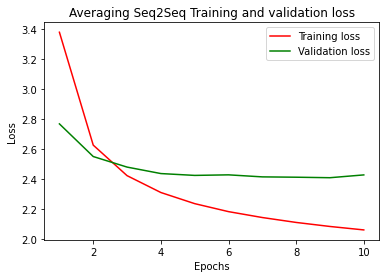

In [ ]:
# Plot History
history_dict = history.history
plt.plot(range(1,epochs+1), history_dict['loss'], 'r', label='Training loss')
plt.plot(range(1,epochs+1), history_dict['val_loss'], 'g', label='Validation loss')
plt.title('Averaging Seq2Seq Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#################################### INFERENCE ENCODER ################################
# Encode the input sequence to get the feature vector
encoder_model = tf.keras.Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      hidden, hidden], name='encoder')
encoder_model.summary()
print('\n\n\n')


################################### INFERENCE DECODER ###############################
# Below tensors will hold the states of the previous time step
decoder_state_input_h = tf.keras.layers.Input(shape=(latent_dim, ))
decoder_state_input_c = tf.keras.layers.Input(shape=(latent_dim, ))
decoder_hidden_state_input = tf.keras.layers.Input(shape=(maxlen, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention
decoder_outputs2 = attention([decoder_hidden_state_input,decoder_outputs2])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = tf.keras.Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2], name='decoder')

decoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      983200      input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 100)          0           embedding[0][0]                  
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30, 100)      10100       embedding[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Load weights
encoder_model.load_weights('vae_enc_weights.h5')
decoder_model.load_weights('vae_dec_weights.h5')

# Test
real = np.load("encoded_jokes.npy", allow_pickle=True)
for i in range(100):
  keyword = keywords[i]
  kw = detokenize(test_kw[i])
  print("KEYWORDS:", [x for x in kw if x != '[PAD]' and x != '[START]'])
  true = detokenize(test_seq[i])
  print("TRUE:", ' '.join([x for x in true if x != '[PAD]' and x != '[START]']))
  generated = decoder_decode(keyword.reshape(1, 30))
  print("GENERATED:", generated)
  print("")

KEYWORDS: ['switch', 'light', 'arguing']
TRUE: how do you end two deaf persons ' arguing ? switch off the light .
GENERATED:  i was able to be able to build a legolas . i was able to build a legolas .

KEYWORDS: ['suckin', 'lot', 'lose', 'hurricane', 'house', 'first', 'common', 'blowin', 'blonde']
TRUE: what does a blonde have in common with a hurricane ? first there is a lot of suckin and blowin , then you lose your house .
GENERATED:  what is the best part about being a blogen ? jokes .

KEYWORDS: ['went', 'floats', 'day', 'circles']
TRUE: i went to a white pride parade the other day . the floats just kept going around in circles about 200 miles per hour .
GENERATED:  ran through a campground you ran through the campground they ran tents .

KEYWORDS: ['would', 'neighbor', 'joke', 'home', 'close']
TRUE: i would make a joke about my neighbor . but it would be too close to home
GENERATED:  nice to a living in a living room for a living room .

KEYWORDS: ['god', 'everything', 'difference

In [ ]:
# Test
start_prompt = "dream"
start_tokens = tokenizer.tokenize(start_prompt)
start_tokens = tf.squeeze(start_tokens,axis=0)
start_tokens = list(tf.squeeze(start_tokens, axis=1).numpy())
start_tokens = keras.preprocessing.sequence.pad_sequences([start_tokens],
                                            value=0,
                                            padding='post',
                                            maxlen=maxlen)[0] 

print("KEYWORDS:", start_prompt)
print("OUTPUT:", decoder_decode(start_tokens.reshape(1, maxlen)))

KEYWORDS: dream
OUTPUT:  what is the best thing about being a good boxer ? you are not a good time travel .


# Joke-Transformer




In [ ]:
########################################## TRANSFORMER ############################################

def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
################ Transformer Params ###########
embed_dim = 256  # Embedding size for each token
num_heads = 3  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer

In [ ]:
# GPT2 Style Transformer
inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block1 = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
x = transformer_block1(x)
transformer_block2 = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
x = transformer_block2(x)
transformer_block3 = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
x = transformer_block3(x)
transformer_block4 = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
x = transformer_block4(x)
outputs = layers.Dense(vocab_size)(x)
model = keras.Model(inputs=inputs, outputs=[outputs, x])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile("adam", loss=[loss_fn, None],)  # No loss and optimization based on word embeddings from transformer block
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
token_and_position_embedding (None, 30, 256)           2524672   
_________________________________________________________________
transformer_block_44 (Transf (None, 30, 256)           921600    
_________________________________________________________________
transformer_block_45 (Transf (None, 30, 256)           921600    
_________________________________________________________________
transformer_block_46 (Transf (None, 30, 256)           921600    
_________________________________________________________________
transformer_block_47 (Transf (None, 30, 256)           921600    
_________________________________________________________________
dense_116 (Dense)            (None, 30, 9832)          2526

In [ ]:
# Fit model
start_prompt = "what do you"
text_gen_callback = TextGenerator(maxlen, start_prompt, tokenizer, top_k=2)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
model.fit(target, 
          np.squeeze(labels), 
          validation_split=0.1, 
          batch_size=batch_size, 
          epochs=epochs, 
          callbacks=[text_gen_callback, es])

In [ ]:
# Save model
model.save_weights('transformer_sub.h5')

In [ ]:
# Testing for overfitting
model.load_weights('transformer_sub.h5')
test_model(model)

In [ ]:
#model.load_weights('transformer_sub.h5')
start_prompt = "what do you"
generate(model, maxlen, start_prompt, top_k=2, tokenizer=tokenizer)

# Joke-GAN (Reconstruction Seq2Seq)

In [ ]:
latent_dim = 100
embedding_dim = 200
latent_dim_0 = int(latent_dim / 2)
r_drop = 0.0
d_drop = 0.4

################################# ENCODER #######################################
# Source input
encoder_inputs = Input(shape=(maxlen, ))

# Embedding layer
enc_emb = Embedding(vocab_size, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM
encoder_bilstm = Bidirectional(LSTM(latent_dim_0, return_state=True,
                     return_sequences=True,
                     dropout=d_drop,
                     recurrent_dropout=r_drop))

_, forward_h, _, backward_h, _ = encoder_bilstm(enc_emb)
hidden = Concatenate()([forward_h, backward_h])

################################# DECODER #######################################
# Produce cell state from hidden variable
reweight_cell = Dense(latent_dim, activation='relu')
cell = reweight_cell(hidden)

# Produce encoder output from hidden variable by repeating and reparameterizing
expand_output = RepeatVector(maxlen)
expanded_outputs = expand_output(hidden)
reweight_output = Dense(latent_dim, activation='relu')
encoder_outputs = reweight_output(expanded_outputs)

# Target inputs
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(vocab_size, latent_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, 
                    dropout=d_drop,
                  recurrent_dropout=r_drop)

(decoder_outputs, h, c) = decoder_lstm(dec_emb, initial_state=[hidden, cell])
layer_norm_1 = LayerNormalization()
decoder_outputs = layer_norm_1(decoder_outputs)

# Attention
decoder_attention = LuongAttentionLayer()
decoder_outputs = decoder_attention([encoder_outputs,decoder_outputs])

# Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.load_weights('/content/reconstructor_weights.h5')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 200)      1966400     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 30, 100), (N 100400      embedding_2[0][0]                
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 100)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3]      

In [ ]:
# Compile and Fit model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
#text_gen_callback = TextGenerator(encoder_model, stepper_model, decoder_model, test[:5], tokenizer)

epochs = 10
history = model.fit([source,target],
                   labels,
                   batch_size=batch_size,
                   validation_split=0.1,
                   epochs=epochs,
                   callbacks=[es])#, text_gen_callback])

Epoch 1/10
645/645 [==============================] - 48s 66ms/step - loss: 4.5263 - val_loss: 3.0264
Epoch 2/10
645/645 [==============================] - 42s 65ms/step - loss: 2.9377 - val_loss: 2.6394
Epoch 3/10
645/645 [==============================] - 41s 64ms/step - loss: 2.5785 - val_loss: 2.3969
Epoch 4/10
645/645 [==============================] - 42s 64ms/step - loss: 2.3358 - val_loss: 2.2101
Epoch 5/10
645/645 [==============================] - 42s 65ms/step - loss: 2.1583 - val_loss: 2.0694
Epoch 6/10
645/645 [==============================] - 41s 64ms/step - loss: 1.9951 - val_loss: 1.9528
Epoch 7/10
645/645 [==============================] - 42s 65ms/step - loss: 1.8564 - val_loss: 1.8563
Epoch 8/10
645/645 [==============================] - 42s 65ms/step - loss: 1.7532 - val_loss: 1.7677
Epoch 9/10
645/645 [==============================] - 41s 64ms/step - loss: 1.6602 - val_loss: 1.6927
Epoch 10/10
645/645 [==============================] - 41s 64ms/step - loss: 1.573

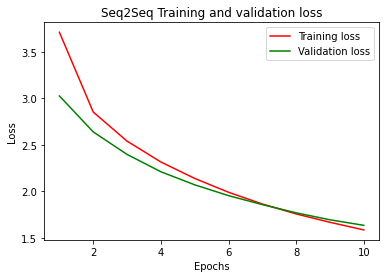

In [ ]:
# Plot History
history_dict = history.history
plt.plot(range(1,epochs+1), history_dict['loss'], 'r', label='Training loss')
plt.plot(range(1,epochs+1), history_dict['val_loss'], 'g', label='Validation loss')
plt.title('Seq2Seq Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# INFERENCE ENCODER
encoder_model = Model(inputs=encoder_inputs, outputs=hidden)


# INFERENCE STEPPER
input_z = Input(shape=(latent_dim, ))

# Obtain the outputs and cell state
cell_s = reweight_cell(input_z)
expanded_z = expand_output(input_z)
outputs_s = reweight_output(expanded_z)
stepper_model = Model(inputs=input_z, outputs=[outputs_s, cell_s])
    


# INFERENCE DECODER
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(maxlen, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])
decoder_outputs2 = layer_norm_1(decoder_outputs2)

# Attention
decoder_outputs2 = decoder_attention([decoder_hidden_state_input,decoder_outputs2])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(topic, start=[2]):
    # Obtain the latent variable
    e_h = encoder_model.predict(topic)
    
    # Use stepper to obtain the encoder outputs and cell state
    (e_out, e_c) = stepper_model.predict(e_h)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the index of start token.
    for i in range(len(start)):
      target_seq[i, i] = start[i]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #sampled_token = reverse_target_word_index[sampled_token_index]
        sampled_token = tokenizer.detokenize([[sampled_token_index]]).to_list()
        sampled_token = sampled_token[0][0].decode("utf-8")

        if sampled_token != '[PAD]':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == '[PAD]' or len(decoded_sentence.split()) \
            >= maxlen - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence.replace(" ##",'')

In [ ]:
# Test
for i in range(10):
  input = test[i]
  true = detokenize(test[i])
  print("TRUE:", ' '.join([x for x in true if x != '[PAD]' and x != '[START]']))
  generated = decode_sequence(input.reshape(1, maxlen))
  print("GENERATED:", generated)
  print("")

TRUE: why was orlando bloom sad when he realised he wasn ' t able to build small toy houses ? because he was legolas .
GENERATED:  why was orlando bloomour sad when he realised he wasn ' t had 5 for lego . because he was toy t spotted

TRUE: why aren ' t there any white jokes on r jokes ? because jokes are the white man is burden .
GENERATED:  why aren ' t there any white jokes on r jokes ? because all jokes survive a real pan ziet .

TRUE: you can ' t run through a campground , you can only ran because its past tents
GENERATED:  you can ' t run through a campground , you can only ran because its past tents

TRUE: the secret of living to 100 years old is patience
GENERATED:  the secret of living to 100 years old is patience

TRUE: why can ' t you get out of a sex cult with r . kelly ? once you are inurine
GENERATED:  why can ' t you get out of a bad man rel ? relax , it should be in maur .

TRUE: what is samsung ceo is favorite movie total recall
GENERATED:  what is samsung producer is

In [ ]:
encoder_model.save_weights('encoder_model_weights.h5')
stepper_model.save_weights('stepper_model_weights.h5')
decoder_model.save_weights('decoder_model_weights.h5')

# Joke-GAN (PyTorch)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader

class Block(nn.Module):
    
    def __init__(self, block_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(block_dim, block_dim),
            nn.ReLU(True),
            nn.Linear(block_dim, block_dim),
        )
    
    def forward(self, x):
        return self.net(x) + x

class Generator(nn.Module):
    
    def __init__(self, n_layers, block_dim):
        super().__init__()

        self.net = nn.Sequential(
            *[Block(block_dim) for _ in range(n_layers)]
        )

    def forward(self, x):
        return self.net(x)

class Critic(nn.Module):
    
    def __init__(self, n_layers, block_dim):
        super().__init__()

        self.net = nn.Sequential(
            *[Block(block_dim) for _ in range(n_layers)]
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
def compute_grad_penalty(critic, real_data, fake_data):
    B = real_data.size(0)
    alpha = torch.FloatTensor(np.random.random((B, 1)))
    if cuda:
        alpha = alpha.cuda()
    sample = alpha*real_data + (1-alpha)*fake_data
    sample.requires_grad_(True)
    score = critic(sample)

    outputs = torch.FloatTensor(B, latent_dim).fill_(1.0)
    outputs.requires_grad_(False)
    if cuda:
        outputs = outputs.cuda()
    grads = autograd.grad(
        outputs=score,
        inputs=sample,
        grad_outputs=outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    #grads = grads.view(B, -1)
    grad_penalty = ((grads.norm(2, dim=1) - 1.) ** 2).mean()
    return grad_penalty


def train_gan(epoch):
    #autoencoder.eval()
    generator.train()
    critic.train()
    c_train_loss = 0.
    g_train_loss = 0.
    g_batches = 0
    for i, x in enumerate(train_loader):
        if cuda:
            x = x.cuda()
        
        # train critic
        B = x.size(0)
        c_optimizer.zero_grad()
        noise = torch.from_numpy(np.random.normal(0, 1, (B,
                                 latent_dim))).float()
        if cuda:
            noise = noise.cuda()
        with torch.no_grad():
            x = x.cpu()
            x = x.numpy()
            z_real = encoder_model(x)
            z_real = z_real.numpy()
            z_real = torch.FloatTensor(z_real).cuda()

        z_fake = generator(noise)
        real_score = critic(z_real)
        fake_score = critic(z_fake)
        grad_penalty = compute_grad_penalty(critic, z_real.data, z_fake.data)
        c_loss = -torch.mean(real_score) + torch.mean(fake_score) + \
                 gp_lambda*grad_penalty
        c_train_loss += c_loss.item()
        c_loss.backward()
        c_optimizer.step()

        # train generator
        if i % n_critic == 0:
            g_batches += 1
            g_optimizer.zero_grad()
            fake_score = critic(generator(noise))
            g_loss = -torch.mean(fake_score)
            g_train_loss += g_loss.item()
            g_loss.backward()
            g_optimizer.step()
        
        if interval > 0 and i % interval == 0:
            print('Epoch: {} | Batch: {}/{} ({:.0f}%) | G Loss: {:.6f} | C Loss: {:.6f}'.format(
                epoch, batch_size*i, len(train_loader.dataset),
                100.*(batch_size*i)/len(train_loader.dataset),
                g_loss.item(), c_loss.item()
            ))
    g_train_loss /= g_batches
    c_train_loss /= len(train_loader)
    print('* (Train) Epoch: {} | G Loss: {:.4f} | C Loss: {:.4f}'.format(
        epoch, g_train_loss, c_train_loss
    ))
    return (g_train_loss, c_train_loss)


def decode(seq):
  sampled_token = tokenizer.detokenize(seq[None,:,:]).to_list()
  sampled_token = sampled_token[0][0]
  sampled_token = [x.decode("utf-8") for x in sampled_token]
  result = " ".join([x for x in sampled_token if x != '[START]'])
  return result

In [ ]:
batch_size = 32
embedding_dim = 200 
latent_dim = 100
vocab_size = 9832
maxlen = 30
seed=0
epochs=1
lr=5e-4
interval=10
cuda=torch.cuda.is_available()
n_layers = 5
block_dim = 100
n_critic = 5
gp_lambda = 10

# Load Data
data = torch.tensor(seq_out,dtype=torch.long)
train_loader = DataLoader(data, batch_size, shuffle=True)

torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
generator = Generator(n_layers, block_dim)
critic = Critic(n_layers, block_dim)

In [ ]:
# Train GAN
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
c_optimizer = optim.Adam(critic.parameters(), lr=lr)

total_loss = []
total_g_loss = []
total_c_loss = []

if cuda:
   #autoencoder = autoencoder.cuda()
   generator = generator.cuda()
   critic = critic.cuda()
    
   print('G Parameters:', sum([p.numel() for p in generator.parameters() if p.requires_grad]))
   print('C Parameters:', sum([p.numel() for p in critic.parameters() if p.requires_grad]))
    
   best_loss = np.inf
    
   for epoch in range(1, epochs + 1):
     g_loss, c_loss = train_gan(epoch)
     loss = g_loss + c_loss
     total_loss.append(loss)
     total_g_loss.append(g_loss)
     total_c_loss.append(c_loss)

     print('Samples:')
     generator.cpu()
     for x in range(10):
        joke = generate_joke()
        print(joke)
          
     if loss < best_loss:
        best_loss = loss
        print('* Saved')
        torch.save(generator.state_dict(), 'generator.th')
        torch.save(critic.state_dict(), 'critic.th')

G Parameters: 101000
C Parameters: 101000
Epoch: 1 | Batch: 0/101728 (0%) | G Loss: -0.071708 | C Loss: -0.007274
Epoch: 1 | Batch: 320/101728 (0%) | G Loss: -0.080412 | C Loss: 0.092105
Epoch: 1 | Batch: 640/101728 (1%) | G Loss: -0.077947 | C Loss: 0.051432
Epoch: 1 | Batch: 960/101728 (1%) | G Loss: -0.082574 | C Loss: 0.020005
Epoch: 1 | Batch: 1280/101728 (1%) | G Loss: -0.082634 | C Loss: 0.005060
Epoch: 1 | Batch: 1600/101728 (2%) | G Loss: -0.082479 | C Loss: 0.007400
Epoch: 1 | Batch: 1920/101728 (2%) | G Loss: -0.079033 | C Loss: 0.021854
Epoch: 1 | Batch: 2240/101728 (2%) | G Loss: -0.071473 | C Loss: 0.005592
Epoch: 1 | Batch: 2560/101728 (3%) | G Loss: -0.062739 | C Loss: 0.004895
Epoch: 1 | Batch: 2880/101728 (3%) | G Loss: -0.054123 | C Loss: 0.005749
Epoch: 1 | Batch: 3200/101728 (3%) | G Loss: -0.045469 | C Loss: -0.007965
Epoch: 1 | Batch: 3520/101728 (3%) | G Loss: -0.039044 | C Loss: -0.008982
Epoch: 1 | Batch: 3840/101728 (4%) | G Loss: -0.033531 | C Loss: -0.01341

In [ ]:
fig, axs = plt.subplots(3)
fig.set_size_inches(10, 10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
axs[0].plot(range(epochs), total_loss)
axs[0].set_title('Total Loss')
axs[1].plot(range(epochs), total_g_loss)
axs[1].set_title('Generator Loss')
axs[2].plot(range(epochs), total_c_loss)
axs[2].set_title('Critic Loss')

In [ ]:
generator = Generator(n_layers, block_dim)
generator.eval()
generator.load_state_dict(torch.load('generator.th', map_location='cpu'))
#stepper_model.load_weights('/content/stepper_model_weights.h5')
#decoder_model.load_weights('/content/decoder_model_weights.h5')

<All keys matched successfully>

In [ ]:
def generate_joke(start=[2], hidden_dim=100):
    # Obtain the latent variable from a random noise
    noise = torch.FloatTensor(np.random.normal(0, 1, (1, hidden_dim)))
    z = generator(noise[None,:,:])
    z = z.squeeze(dim=1)
    z = z.cpu()
    e_h = z.detach().numpy()
    
    # Use stepper to obtain the encoder outputs and cell state
    (e_out, e_c) = stepper_model.predict(e_h)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the index of start token.
    for i in range(len(start)):
      target_seq[i, i] = start[i]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #sampled_token = reverse_target_word_index[sampled_token_index]
        sampled_token = tokenizer.detokenize([[sampled_token_index]]).to_list()
        sampled_token = sampled_token[0][0].decode("utf-8")

        if sampled_token != '[PAD]':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == '[PAD]' or len(decoded_sentence.split()) \
            >= maxlen - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence.replace(" ##",'')

In [ ]:
for x in range(10):
  joke = generate_joke()
  print(joke)

# Clean and Explore (Dont Run)

In [ ]:
############################################# SETUP ################################################
jokes = np.load("jokes.npy", allow_pickle=True)
jokes = [x[1] for x in jokes if len(x[1].split()) <= 30]
print("No of Jokes:", len(jokes))
print("Samples:",jokes[0])

In [ ]:
def unify(text):
  text = text.lower()
  tokenizer = RegexpTokenizer(r'[A-Za-z0-9?-?,.\']+')
  toks = tokenizer.tokenize(text)
  text = " ".join(toks)
  # separate important punctiations
  text = text.replace(",", " , ")
  text = text.replace("...", "")
  text = text.replace("..", "")
  text = text.replace("....", "")
  text = text.replace(".....", "")
  text = text.replace(".", " . ")
  text = text.replace("! ", " ! ")
  text = text.replace("? ", " ? ")
  text = text.replace("-", " - ")
  text = text.replace("&", "and")
  text = text.replace("'s ", " is ")
  text = text.replace(" m ", " am ")
  text = text.replace("'ve ", " have ")
  text = text.replace("'re ", " are ")
  text = text.replace("'d ", " would ")
  #text = text.replace("n't", " not")
  text = text.replace(" ll ", " will ")
  text = text.replace(" re ", " are ")
  text = text.replace(" ve ", " have ")
  text = text.replace(" d ", " would ")
  text = text.replace(" u ", " you ")
  text = text.replace(" s ", " is ")
  #text = text.replace(":", " , ")
  #text = text.replace(";", " , ")
  text = text.replace("'", " ' ")
  #text = text.replace('"', ' " ')
  #text = text.replace('[', '')
  #text = text.replace(']', '')

  # tokenize using regular expression
  #tokenizer = RegexpTokenizer(r'[A-Za-z0-9?!-?,.\']+')
  #toks = tokenizer.tokenize(text)

  #return "".join(toks)
  return text

# Call
jokes = [unify(x) for x in jokes]

In [ ]:
jokes[:100]

In [ ]:
# Combine jokes to form a long sequence
corpus = " ".join(jokes)
corpus[:1000]

In [ ]:
# Save the cleaned short jokes 
np.save("short_jokes.npy", jokes)

In [ ]:
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white', collocations=False, stopwords = STOPWORDS).generate(corpus)

# Plot word cloud
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
# Get a dictionary of words by frequency and print the most frequent words
tokenized_jokes = corpus.split(" ")
count = Counter(tokenized_jokes)
unigrams = {k: v for k, v in sorted(count.items(), key=lambda item: item[1], reverse=True)}
bigrams = Counter(ngrams(tokenized_jokes,2))
trigrams = Counter(ngrams(tokenized_jokes,3))

# Get vocabulary and print size
vocab = list(set(count.keys()))
print("Vocab Size:", len(vocab))

In [ ]:
# Create data frames for the frequencies
unigrams = pd.DataFrame(unigrams.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
bigrams = pd.DataFrame(bigrams.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
trigrams = pd.DataFrame(trigrams.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)

In [ ]:
# Frequency of frequencies
unigrams.groupby(['frequency']).count()

In [ ]:
unigrams.tail(30)

In [ ]:
# create subplot of the different data frames
fig, axes = plt.subplots(3,1,figsize=(8,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=unigrams.head(30))
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=bigrams.head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams.head(30))

In [ ]:
# set up dictionary of words
words = set(nltk.corpus.words.words())
count = []

# Tokenise jokes
tokenized_jokes = [jokes.split(" ") for x in jokes]

# Set up engine for checking if word is singular 
p = inflect.engine()

for joke in tokenized_jokes:
  # Assume all words are real
  real = True
  # Check to see if any word does not exist
  for w in joke:
    if w not in words:
      # Count any sentence with such words as false
      real = False
  count.append(real)

count = Counter(count)
count

# Keyword Analysis (Dont Run)

In [ ]:
# Load and detokenize data
#data = np.load("short_jokes.npy", allow_pickle=True)
jokes = np.load("encoded_jokes.npy", allow_pickle=True)
jokes = tokenizer.detokenize(jokes)
jokes = list(jokes.numpy())
data = []

for x in jokes:
  x = [y.decode("utf-8") for y in x]
  x = " ".join([y for y in x if y != '[PAD]'])
  data.append(x)


# Extract keywords
r = Rake(max_length=1)
keywords = []

for x in data:
  kw = r.extract_keywords_from_text(x)
  kw = r.get_ranked_phrases()
  keywords.append(kw)


# Tokenize and encode keywords
keywords_int = tf.ragged.constant(keywords)
keywords_int = tokenizer.tokenize(keywords_int)
# Reshape
keywords_int = keywords_int.merge_dims(-2,-1).to_list()

# Squeeze list
seq_in = []
for x in keywords_int:
  x = [item for sublist in x for item in sublist]
  seq_in.append(x)

# Pad sequences
seq_in = keras.preprocessing.sequence.pad_sequences(seq_in,
                                            value=0,
                                            padding='post',
                                            maxlen=30)

# Prepare the sequences
seq_in = np.insert(seq_in[:,:-1], 0, 2, axis=1)
seq_out = np.load("encoded_jokes.npy", allow_pickle=True)[:, :-1]
seq_out = np.insert(seq_out[:,:-1], 0, 2, axis=1)
seq_lab = np.expand_dims(seq_out[:, 1:],axis=2)
seq_lab = keras.preprocessing.sequence.pad_sequences(seq_lab,
                                            value=0,
                                            padding='post',
                                            maxlen=30)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/ragged/ragged_tensor.py:2053: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(rows)


Counter({0: 5982,
         1: 16129,
         2: 22359,
         3: 21902,
         4: 16497,
         5: 10362,
         6: 5187,
         7: 2223,
         8: 783,
         9: 231,
         10: 62,
         11: 11})

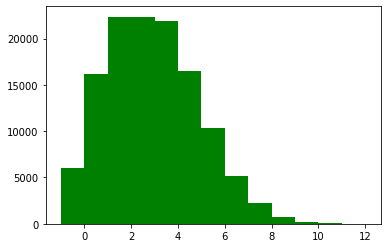

In [ ]:
# Analyse keywords
corpus = [j for i in keywords for j in i]
keywords_freq_dict = Counter(corpus)
lengths = [len(x) for x in keywords]
kw_length_frequency = Counter(lengths)
plt.bar(kw_length_frequency.keys(), kw_length_frequency.values(), 2, color='g')
kw_length_frequency

No of keywords: 24757


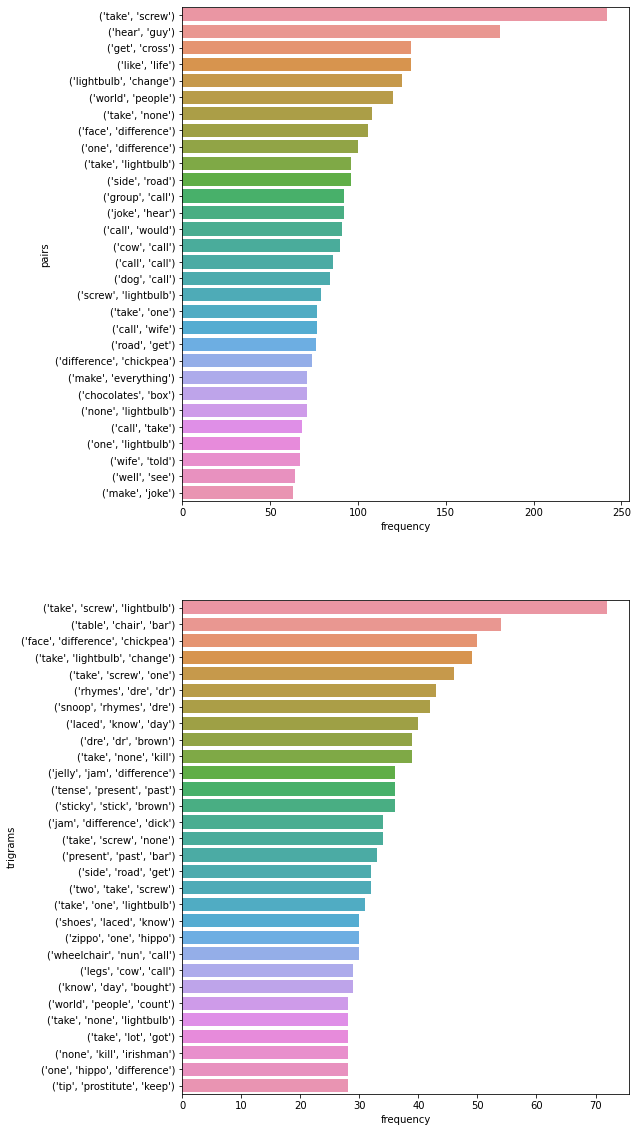

In [ ]:
kw = [item for sublist in keywords for item in sublist]
print("No of keywords:", len(list(set(kw))))

count = Counter(kw)
#unigrams = {k: v for k, v in sorted(count.items(), key=lambda item: item[1], reverse=True)}
bigrams = Counter(ngrams(kw,2))
trigrams = Counter(ngrams(kw,3))
quadgrams = Counter(ngrams(kw,4))
pentgrams = Counter(ngrams(kw,5))
# Create data frames for the frequencies
#unigrams = pd.DataFrame(unigrams.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
bigrams = pd.DataFrame(bigrams.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
trigrams = pd.DataFrame(trigrams.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)
quadgrams = pd.DataFrame(quadgrams.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
pentgrams = pd.DataFrame(pentgrams.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
# create subplot of the different data frames
fig, axes = plt.subplots(2,1,figsize=(8,20))
#sns.barplot(ax=axes[0],x='frequency',y='word',data=unigrams.head(30))
sns.barplot(ax=axes[0],x='frequency',y='pairs',data=bigrams.head(30))
sns.barplot(ax=axes[1],x='frequency',y='trigrams',data=trigrams.head(30))
#sns.barplot(ax=axes[0],x='frequency',y='pairs',data=quadgrams.head(30))
#sns.barplot(ax=axes[1],x='frequency',y='pairs',data=pentgrams.head(30))

In [ ]:
kw_joined = " ".join(kw)

# Sensoring some explicit words
kw_joined = kw_joined.replace("dick", "dxxk")
kw_joined = kw_joined.replace("ass", "axs")
kw_joined = kw_joined.replace("fuck", "fxxk")

In [ ]:
# Generate word cloud
wordcloud = WordCloud(width = 4000, height = 8000, random_state=1, background_color='white', collocations=False, stopwords = STOPWORDS).generate(kw_joined)

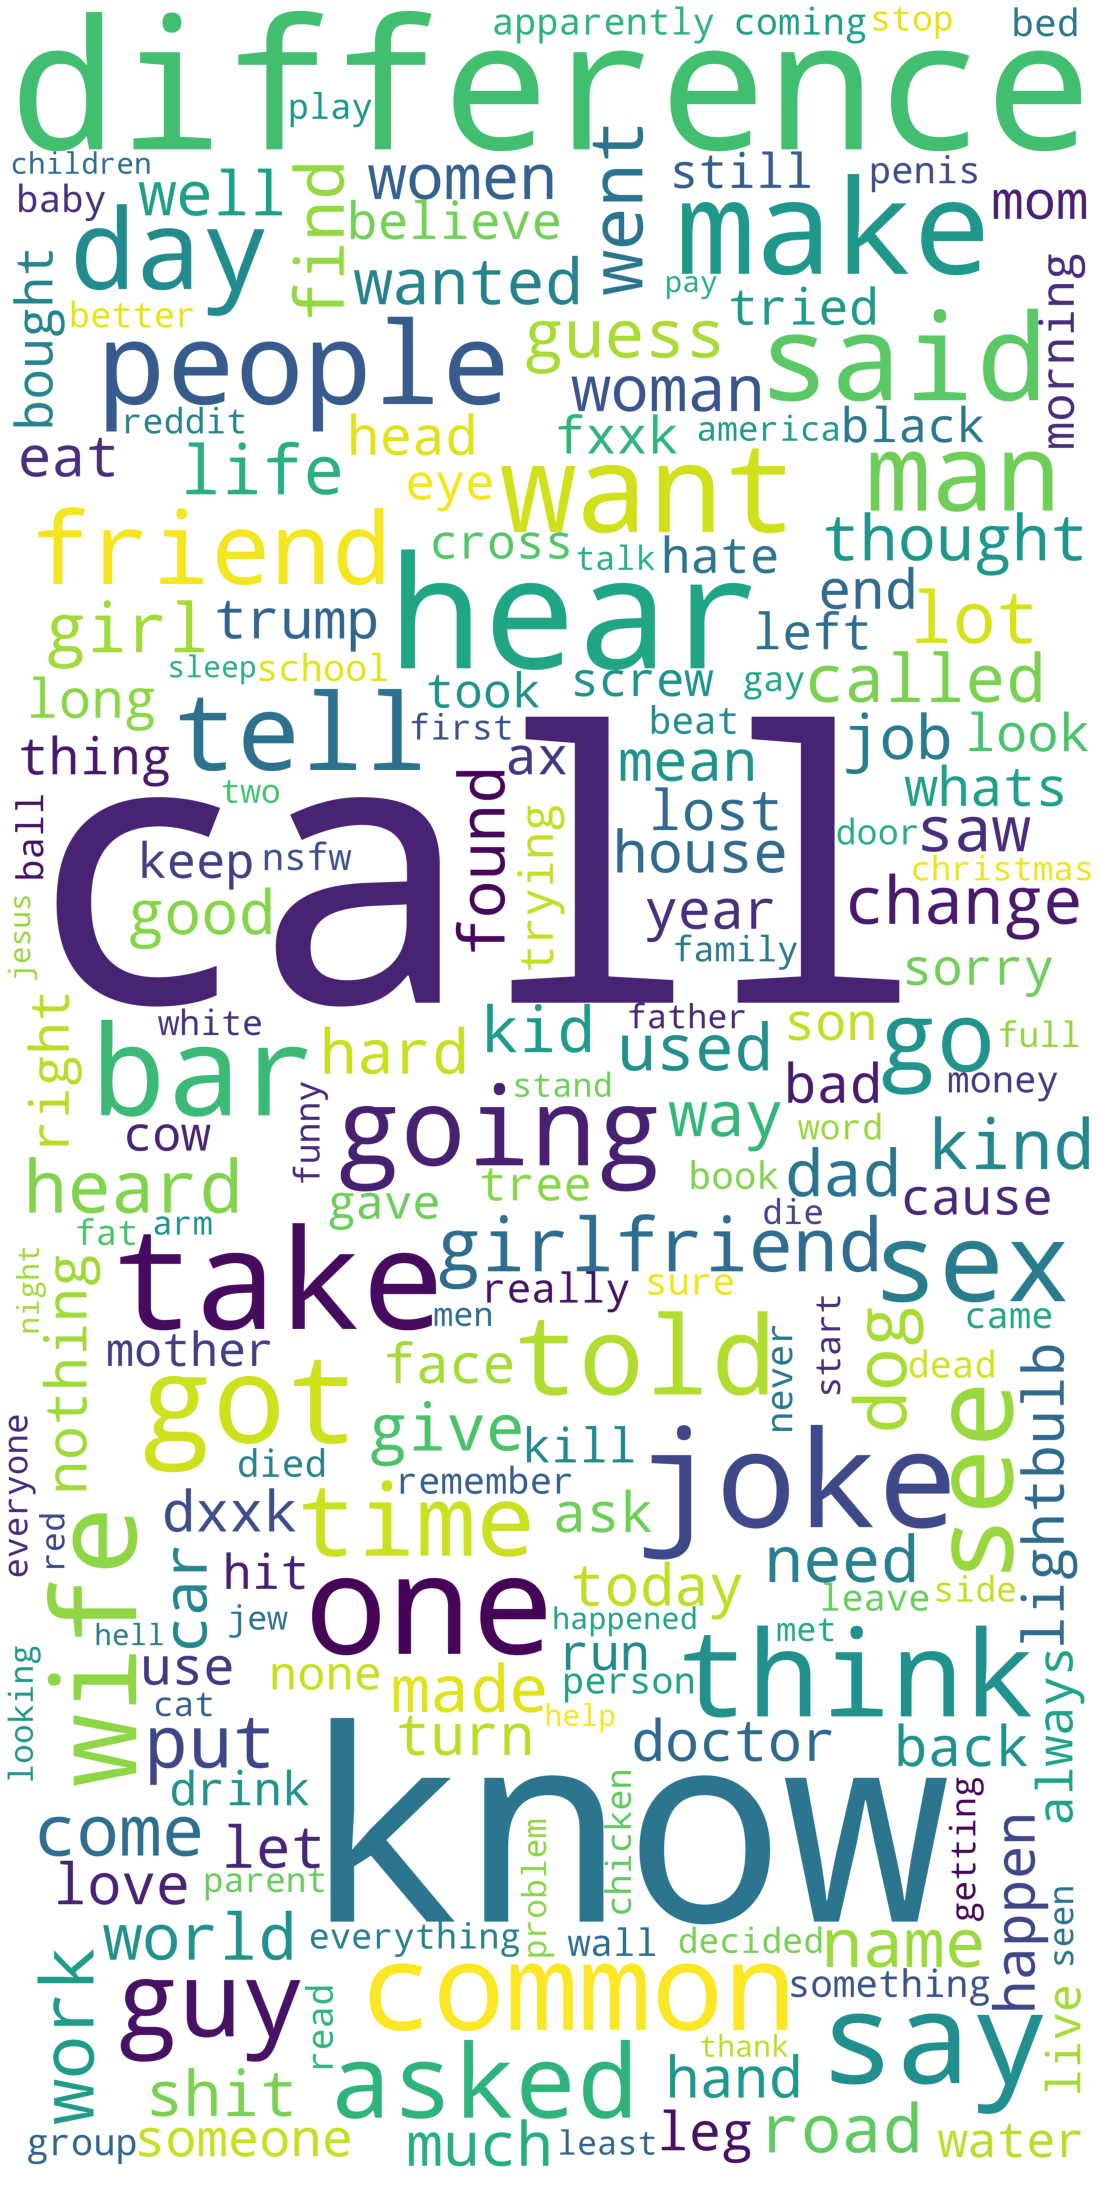

In [ ]:
# Plot word cloud
plt.figure(figsize=(20, 40))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Subword/Word Vocab (Dont Run)

In [ ]:
# Create subword vocabulary
bert_tokenizer_params=dict(lower_case=True)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

# Crete the dataset
data = tf.data.Dataset.from_tensor_slices(train)
data = dataset.shuffle(buffer_size=256)

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 10000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

vocab = bert_vocab.bert_vocab_from_dataset(
    data.batch(1000).prefetch(2),
    **bert_vocab_args
)

In [ ]:
print(len(vocab))

9832


In [ ]:
# Save vocab as a textfile
with open('vocab.txt', 'w') as f:
    for token in vocab:
      print(token, file=f)

In [ ]:
############################### LOAD SAVED SHORT JOKES INSTEAD ###################################
jokes = np.load("short_jokes.npy", allow_pickle=True)
print("No of Jokes:", len(jokes))
print("Samples:",jokes[:10])

No of Jokes: 112260
Samples: ["how do you end two deaf persons '  arguing ? switch off the light . "
 'what does a blonde have in common with a hurricane ? first there is a lot of suckin and blowin ,  then you lose your house . '
 'i went to a white pride parade the other day .  the floats just kept going around in circles about 200 miles per hour . '
 'i would make a joke about my neighbor .  but it would be too close to home'
 'what is the difference between god and you ex wife ? god only wants 10 things .  your ex wife wants half of everything . '
 'i swear ,  i will castrate you do it ,  you won t .  no balls bro . '
 'the first thing a man notices about a woman is her eyes and when he made sure it is not looking his way , he checks out her tits '
 'what is your favourite insult joke ? i will get it started 2090 called ,  you are dead and nobody misses you'
 'trump hows that mexican mall going ? mall ? we thought you said wall trump no way that is harsh ,  also hows that muslim ban

In [ ]:
# Create tokenizer
tokenizer = tensorflow_text.BertTokenizer('vocab.txt', **dict(lower_case=True))
# Get ints
jokes_ints = tokenizer.tokenize(jokes)
# Reshape
jokes_ints = jokes_ints.merge_dims(-2,-1).to_list()

In [ ]:
# Drop jokes with more than 30 tokens
data = [x for x in jokes_ints if len(x) <= 30]

# Pad
data = keras.preprocessing.sequence.pad_sequences(data,
                                            value=0,
                                            padding='post',
                                            maxlen=30+1)

print("No of Samples:", len(data))

# Save encoded and padded jokes
np.save("encoded_jokes.npy", data)

No of Samples: 101728


In [ ]:
def detokenize(indices):
  word_tokens = tokenizer.detokenize([indices]).to_list()
  word_tokens = [x.decode("utf-8") for x in word_tokens[0]]
  return word_tokens
  #return " ".join([x for x in word_tokens if x != '[PAD]'])

In [ ]:
# Detokenize
samples = tokenizer.detokenize(jokes)
samples = list(samples.numpy())

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/ragged/ragged_tensor.py:2053: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(rows)


In [ ]:
# decode and join
corpus = []
for x in samples:
  x = [y.decode("utf-8") for y in x]
  corpus.append([y for y in x if y != '[PAD]'])

In [ ]:
# merge the tokens
corpus = [j for i in corpus for j in i]

In [ ]:
count = Counter(corpus)
unigrams = {k: v for k, v in sorted(count.items(), key=lambda item: item[1], reverse=True)}
bigrams = Counter(ngrams(corpus,2))
trigrams = Counter(ngrams(corpus,3))
quadgrams = Counter(ngrams(corpus,4))
pentgrams = Counter(ngrams(corpus,5))

In [ ]:
# Create data frames for the frequencies
unigrams = pd.DataFrame(unigrams.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
bigrams = pd.DataFrame(bigrams.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
trigrams = pd.DataFrame(trigrams.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)
quadgrams = pd.DataFrame(quadgrams.items(),columns=['quadgrams','frequency']).sort_values(by='frequency',ascending=False)
pentgrams = pd.DataFrame(pentgrams.items(),columns=['pentgrams','frequency']).sort_values(by='frequency',ascending=False)

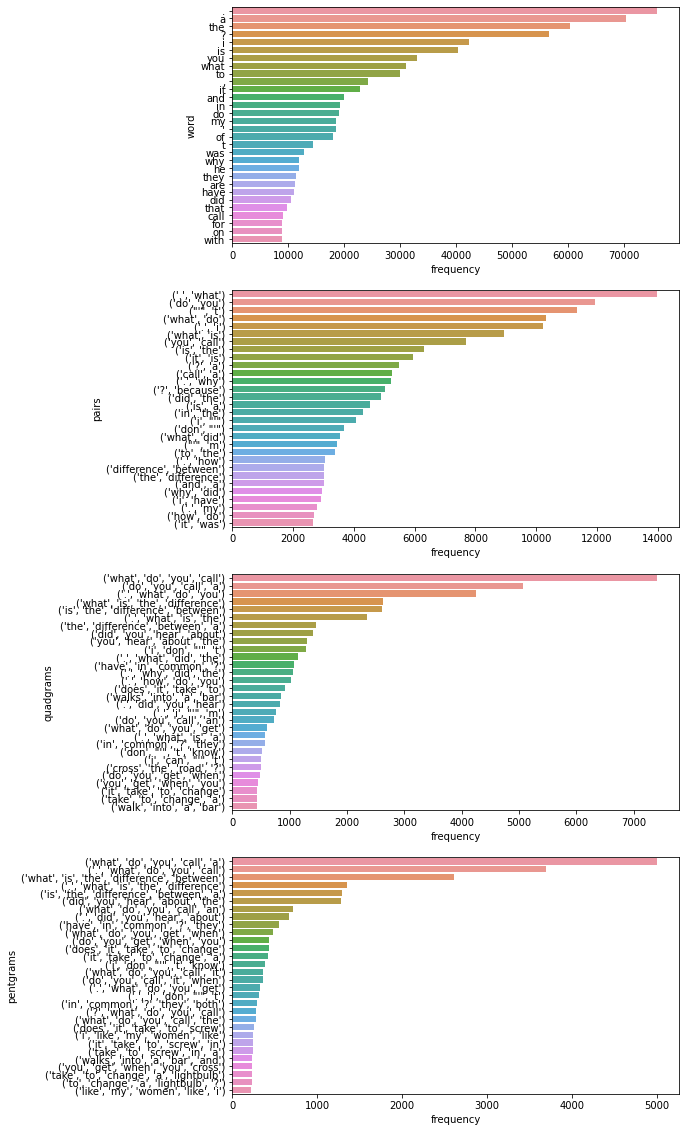

In [ ]:
# create subplot of the different data frames
fig, axes = plt.subplots(4,1,figsize=(8,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=unigrams.head(30))
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=bigrams.head(30))
sns.barplot(ax=axes[2],x='frequency',y='quadgrams',data=quadgrams.head(30))
sns.barplot(ax=axes[3],x='frequency',y='pentgrams',data=pentgrams.head(30))

In [ ]:
pentgrams.head(50)

,pentgrams,frequency
536,"(what, do, you, call, a)",5007
660,"(., what, do, you, call)",3695
84,"(what, is, the, difference, between)",2606
519,"(., what, is, the, difference)",1345
4669,"(is, the, difference, between, a)",1287
1150,"(did, you, hear, about, the)",1281
575,"(what, do, you, call, an)",716
1149,"(., did, you, hear, about)",669
6021,"(have, in, common, ?, they)",548
1673,"(what, do, you, get, when)",476


# Dataset Preparation (Archived)

In [ ]:
######################################## DATASET PREPARATION #######################################
jokes = np.load("short_jokes.npy", allow_pickle=True)

idx = int(len(jokes) * 0.9)
train = jokes[:idx]
valid = jokes[idx:]
 
dataset = tf.data.Dataset.from_tensor_slices(train)
dataset = dataset.shuffle(buffer_size=256)
dataset = dataset.batch(batch_size)
 
def custom_standardization(input_string):
    #Remove html line-break tags and handle punctuation
    lowercased = tf.strings.lower(input_string)
    stripped_html = tf.strings.regex_replace(lowercased, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")
 
 
# Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(dataset)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices
print(len(vocab))
 
 
def prepare_lm_inputs_labels(text):
    #Shift word sequences by 1 position so that the target for position (i) is
    #word at position (i+1). The model will use all words up till position (i)
    #to predict the next word.

    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y
 
dataset = dataset.map(prepare_lm_inputs_labels)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
 
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index
print(dataset)


39999
<PrefetchDataset shapes: ((None, 50), (None, 50)), types: (tf.int64, tf.int64)>


In [ ]:
# Validation Set
valid = tf.data.Dataset.from_tensor_slices(valid)
valid = valid.shuffle(buffer_size=256)
valid = valid.batch(batch_size)
valid = valid.map(prepare_lm_inputs_labels)
valid = valid.prefetch(tf.data.experimental.AUTOTUNE)
print(valid)

<PrefetchDataset shapes: ((None, 50), (None, 50)), types: (tf.int64, tf.int64)>


In [ ]:
for joke in jokes[:10]:
  print(joke)
  print(custom_standardization(joke))
  print(" ")

how do you end two deaf persons' arguing? switch off the light.
tf.Tensor(b"how do you end two deaf persons ' arguing ? switch off the light .", shape=(), dtype=string)
 
what does a blonde have in common with a hurricane? first there is a lot of suckin and blowin, then you lose your house.
tf.Tensor(b'what does a blonde have in common with a hurricane ? first there is a lot of suckin and blowin , then you lose your house .', shape=(), dtype=string)
 
i went to a white pride parade the other day. the floats just kept going around in circles about 200 miles per hour.
tf.Tensor(b'i went to a white pride parade the other day . the floats just kept going around in circles about 200 miles per hour .', shape=(), dtype=string)
 
going to make an app. i have decided to create an app where you tour museums and art galleries finding famous paintings.  i am going to call it van gogh.   source - me
tf.Tensor(b'going to make an app . i have decided to create an app where you tour museums and art ga

# Utils (Archived)

In [ ]:
# Generator Callback
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")

In [ ]:
####################################### Beam Search Generator ##############################
def generate(model, max_tokens, start_tokens, index_to_word, top_k=5, print_every=1):
        start_tokens = [_ for _ in start_tokens]
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = model.predict(x)

            logits = y[0][sample_index]
            logits, indices = tf.math.top_k(logits, k=top_k, sorted=True)
            indices = np.asarray(indices).astype("int32")
            preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
            preds = np.asarray(preds).astype("float32")
            sample_token = np.random.choice(indices, p=preds)

            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
            txt = " ".join(
            [index_to_word[_] for _ in start_tokens])
        return txt


####################### TEST ################################
def test_model(model):
  samples = []
  samples.append("how do you end two deaf persons")
  samples.append("What does a blonde have in common with a hurricane")
  samples.append("I went to a white pride parade the other day")
  samples.append("Going to make an app")
  samples.append("i would  make a joke about my neighbor")
  samples.append("what is the difference between god and you")

  # Check if model prints the correct sentence, given first 7 tokens
  for i in range(len(samples)):
    start_tokens = [word_to_index.get(_, 1) for _ in samples[i].lower().split()]
    num_tokens_generated = 50
    sample = generate(model, num_tokens_generated, start_tokens, vocab)
    print("TRUE: ", jokes[i])
    print("INPUT: ", samples[i])
    print("GENERATED: ",sample)
    print("")

In [ ]:
start_prompt = "what do you"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.lower().split()]
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

# BiLstm (Archived)

In [ ]:
# Simple BiLSTM
inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
# Embedding
x = layers.Embedding(vocab_size, 100, input_length=maxlen)(inputs)
# BiLSTM
x = layers.Bidirectional(layers.LSTM(100,return_sequences=True))(x)
# Outputs
outputs = layers.Dense(vocab_size)(x)

# Setup model
model = keras.Model(inputs=inputs, outputs=[outputs, x])
# Loss
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile
model.compile("adam", loss=[loss_fn, None],)  # No loss and optimization based on word embeddings from transformer block
# Summarize
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 30, 100)           983200    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 30, 200)           160800    
_________________________________________________________________
dense_9 (Dense)              (None, 30, 9832)          1976232   
Total params: 3,120,232
Trainable params: 3,120,232
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit model
history = model.fit(dataset, epochs=100, validation_data=valid, callbacks=[text_gen_callback])

# Save model
model.save_weights('bilstm.h5')

# Download model
files.download('bilstm.h5')

Epoch 1/100
59/59 [==============================] - 16s 231ms/step - loss: 6.4129 - dense_28_loss: 6.4129 - val_loss: 3.6105 - val_dense_28_loss: 3.6105
generated text:
how do you end two deaf  is . ,  to                   "  is     . . a .      .

Epoch 2/100
59/59 [==============================] - 13s 218ms/step - loss: 3.3789 - dense_28_loss: 3.3789 - val_loss: 3.2621 - val_dense_28_loss: 3.2621
generated text:
how do you end two deaf  .           ,                            to

Epoch 3/100
59/59 [==============================] - 13s 218ms/step - loss: 2.9527 - dense_28_loss: 2.9527 - val_loss: 2.9872 - val_dense_28_loss: 2.9872
generated text:
how do you end two deaf to a you a                      and               

Epoch 4/100
59/59 [==============================] - 13s 219ms/step - loss: 2.8331 - dense_28_loss: 2.8331 - val_loss: 2.9492 - val_dense_28_loss: 2.9492
generated text:
how do you end two deaf a a                                       

Epoch 5/100
59/59 [=======

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

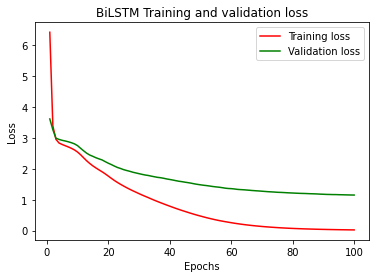

In [ ]:
# Plot History
history_dict = history.history
plt.plot(range(1,epochs+1), history_dict['loss'], 'r', label='Training loss')
plt.plot(range(1,epochs+1), history_dict['val_loss'], 'g', label='Validation loss')
plt.title('BiLSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Test
model.load_weights('bilstm.h5')
test_model(model)

TRUE:  How do you end two deaf persons' arguing? Switch off the light.
INPUT:  how do you end two deaf persons
GENERATED:  how do you end two deaf persons lawyers                                                  

TRUE:  What does a blonde have in common with a hurricane? First there’s a lot of suckin and blowin, then you lose your house.
INPUT:  What does a blonde have in common with a hurricane
GENERATED:  what does a blonde have in common with a hurricane                                                   

TRUE:  I went to a white pride parade the other day. The floats just kept going around in circles about 200 miles per hour.
INPUT:  I went to a white pride parade the other day
GENERATED:  i went to a white pride parade the other day                                                   

TRUE:  Going to make an app. I've decided to create an app where you tour museums and art galleries finding famous paintings.  I'm going to call it Van Gogh.   Source - Me
INPUT:  Going to make an ap

# Seq2Seq

In [ ]:
class AttentionLayer(Layer):
  def compute_mask(self, inputs, mask=None):
    if mask == None:
      return None
    return mask[1]

  def compute_output_shape(self, input_shape):
    return (input_shape[1][0],input_shape[1][1],input_shape[1][2]*2)


  def call(self, inputs, mask=None):
    encoder_outputs, decoder_outputs = inputs

    # transpose the dimensions of decoder outputs
    decoder_outputs_t = K.permute_dimensions(decoder_outputs, (0,2,1))

    # calculate luong score
    luong_score = K.batch_dot(encoder_outputs,decoder_outputs_t)
    luong_score = K.softmax(luong_score, axis=1) # along the 2nd axis

    # expand the dimensions of luong score and encoded outputs to enable multiplication
    luong_score = K.expand_dims(luong_score, axis=-1) # along last axis
    encoder_outputs = K.expand_dims(encoder_outputs, axis=2) # along 2nd axis

    # get encoded vector
    encoder_vector = encoder_outputs * luong_score
    encoder_vector = K.sum(encoder_vector, axis=1, keepdims=False)

    # [batch,max_dec,2*emb]
    new_decoder_outputs = K.concatenate([decoder_outputs, encoder_vector])

    return new_decoder_outputs

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
latent_dim = 300
embedding_dim = 200
max_text_len = maxlen

# Encoder
encoder_inputs = Input(shape=(11, ))

# Embedding layer
enc_emb = Embedding(vocab_size, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.0)
(encoder_outputs, state_h, state_c) = encoder_lstm3(enc_emb)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(vocab_size, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.0)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention
decoder_attention = AttentionLayer()
decoder_outputs = decoder_attention([encoder_outputs,decoder_outputs])

# Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 11, 200)      1966400     input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 11, 300), (N 601200      embedding_2[0][0]                
____________________________________________________________________________________________

In [ ]:
# Compile and Fit model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)

epochs = 100
history = model.fit([seq_in,seq_out],
                   seq_lab,
                   batch_size=batch_size,
                   validation_split=0.1,
                   epochs=epochs,
                   callbacks=[es])

Epoch 1/100
716/716 [==============================] - 65s 63ms/step - loss: 4.0602 - val_loss: 3.2072
Epoch 2/100
716/716 [==============================] - 44s 62ms/step - loss: 3.1335 - val_loss: 2.9952
Epoch 3/100
716/716 [==============================] - 44s 62ms/step - loss: 2.9060 - val_loss: 2.8442
Epoch 4/100
716/716 [==============================] - 44s 62ms/step - loss: 2.7620 - val_loss: 2.7428
Epoch 5/100
716/716 [==============================] - 44s 62ms/step - loss: 2.6357 - val_loss: 2.6612
Epoch 6/100
716/716 [==============================] - 44s 61ms/step - loss: 2.5440 - val_loss: 2.5984
Epoch 7/100
716/716 [==============================] - 44s 62ms/step - loss: 2.4587 - val_loss: 2.5473
Epoch 8/100
716/716 [==============================] - 44s 62ms/step - loss: 2.3946 - val_loss: 2.5093
Epoch 9/100
716/716 [==============================] - 44s 62ms/step - loss: 2.3369 - val_loss: 2.4726
Epoch 10/100
716/716 [==============================] - 44s 62ms/step - l

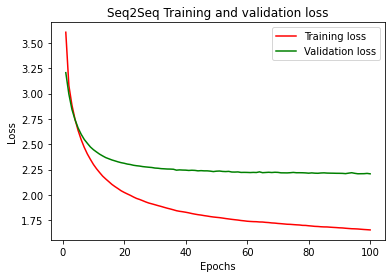

In [ ]:
# Plot History
history_dict = history.history
plt.plot(range(1,epochs+1), history_dict['loss'], 'r', label='Training loss')
plt.plot(range(1,epochs+1), history_dict['val_loss'], 'g', label='Validation loss')
plt.title('Seq2Seq Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(11, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# Attention
decoder_outputs2 = decoder_attention([decoder_hidden_state_input,decoder_outputs2])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
# Test
real = np.load("encoded_jokes.npy", allow_pickle=True)
for i in range(6):
  keywords = seq_in[i]
  kw = detokenize(keywords)
  print("KEYWORDS:", [x for x in kw if x != '[PAD]' and x != '[START]'])
  true = detokenize(real[i])
  print("TRUE:", ' '.join([x for x in true if x != '[PAD]']))
  generated = decode_sequence(keywords.reshape(1, 11))
  print("GENERATED:", generated)
  print("")

KEYWORDS: ['switch', 'light', 'arguing']
TRUE: how do you end two deaf persons ' arguing ? switch off the light .
GENERATED:  how do you switch a light in a light switch ? you switch off in the light switch .

KEYWORDS: ['suckin', 'lot', 'lose', 'hurricane', 'house', 'first', 'common', 'blowin']
TRUE: what does a blonde have in common with a hurricane ? first there is a lot of suckin and blowin , then you lose your house .
GENERATED:  what does a hurricane and a hurricane have in common ? they both blow your blow up and suckin and then blow your house .

KEYWORDS: ['went', 'floats', 'day', 'circles']
TRUE: i went to a white pride parade the other day . the floats just kept going around in circles about 200 miles per hour .
GENERATED:  i went to a zoo the other day but it was a nice day . i was going to buy some shit .

KEYWORDS: ['would', 'neighbor', 'joke', 'home', 'close']
TRUE: i would make a joke about my neighbor . but it would be too close to home
GENERATED:  my neighbor is so cl

In [ ]:
# Save models
with open('encoder_model.json', 'w', encoding='utf8') as f:
    f.write(encoder_model.to_json())
encoder_model.save_weights('encoder_model_weights.h5')

with open('decoder_model.json', 'w', encoding='utf8') as f:
    f.write(decoder_model.to_json())
decoder_model.save_weights('decoder_model_weights.h5')

In [ ]:
# Download models and weights
files.download('encoder_model.json)
files.download('encoder_model_weights.h5')
files.download('decoder_model.json)
files.download('decoder_model_weights.h5')

In [ ]:
# Load models and weights
encoder_model = load_model('encoder_model.json', 'encoder_model_weights.h5')
decoder_model = load_model('decoder_model.json', 'decoder_model_weights.h5')

In [ ]:
# Test
start_prompt = "trump"
start_tokens = tokenizer.tokenize(start_prompt)
start_tokens = tf.squeeze(start_tokens,axis=0)
start_tokens = list(tf.squeeze(start_tokens, axis=1).numpy())
start_tokens = keras.preprocessing.sequence.pad_sequences([start_tokens],
                                            value=0,
                                            padding='post',
                                            maxlen=11)[0] 

print("KEYWORDS:", start_prompt)
print("OUTPUT:", decode_sequence(start_tokens.reshape(1, 11)))

KEYWORDS: trump
OUTPUT:  what is the best part about eating a black guy ? a shot knock


# BiLSTM

In [ ]:
# Simple BiLSTM
inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
# Embedding
x = layers.Embedding(vocab_size, 100, input_length=maxlen)(inputs)
# BiLSTM
x = layers.Bidirectional(layers.LSTM(100,return_sequences=True))(x)
# Outputs
outputs = layers.Dense(vocab_size)(x)

# Setup model
model = keras.Model(inputs=inputs, outputs=[outputs, x])
# Loss
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile
model.compile(optimizer="adam", loss=[loss_fn, None],)
# Summarize
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 30, 100)           983200    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 30, 200)           160800    
_________________________________________________________________
dense_22 (Dense)             (None, 30, 9832)          1976232   
Total params: 3,120,232
Trainable params: 3,120,232
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 10

# Fit model
history = model.fit(dataset, epochs=epochs, validation_data=valid, callbacks=[text_gen_callback])

Epoch 1/10
715/715 [==============================] - 29s 35ms/step - loss: 3.8340 - dense_22_loss: 3.8340 - val_loss: 2.8656 - val_dense_22_loss: 2.8656
generated text:
what do you call when

Epoch 2/10
715/715 [==============================] - 25s 35ms/step - loss: 2.3894 - dense_22_loss: 2.3894 - val_loss: 2.0240 - val_dense_22_loss: 2.0240
generated text:
what do you know do

Epoch 3/10
715/715 [==============================] - 25s 34ms/step - loss: 1.7467 - dense_22_loss: 1.7467 - val_loss: 1.5164 - val_dense_22_loss: 1.5164
generated text:
what do you say when when do

Epoch 4/10
715/715 [==============================] - 25s 34ms/step - loss: 1.2826 - dense_22_loss: 1.2826 - val_loss: 1.1212 - val_dense_22_loss: 1.1212
generated text:
what do you say

Epoch 5/10
715/715 [==============================] - 25s 34ms/step - loss: 0.9257 - dense_22_loss: 0.9257 - val_loss: 0.8228 - val_dense_22_loss: 0.8228
generated text:
what do you say

Epoch 6/10
715/715 [======================

In [ ]:
# Save model
model.save_weights('bilstm_sub.h5')

# Download model
files.download('bilstm_sub.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Plot History
history_dict = history.history
plt.plot(range(1,epochs+1), history_dict['loss'], 'r', label='Training loss')
plt.plot(range(1,epochs+1), history_dict['val_loss'], 'g', label='Validation loss')
plt.title('BiLSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
start_prompt = "how do"
start_tokens = tokenizer.tokenize(start_prompt)
start_tokens = tf.squeeze(start_tokens,axis=0)
start_tokens = list(tf.squeeze(start_tokens, axis=1).numpy())
generate(model, maxlen, start_tokens, tokenizer)

In [ ]:
# Test
#model.load_weights('bilstm_sub.h5')
test_model(model)

TRUE:  how do you end two deaf persons ' arguing ? switch off the light .
INPUT:  how do you end two deaf persons '
GENERATED:  how do you end two deaf persons ' say alike alike alike alike alike alike alike alike cells ? racists racists racists racists racists racists racists racists racists racists racists yourself yourself yourself yourself yourself yourself yourself yourself yourself

TRUE:  what does a blonde have in common with a hurricane ? first there is a lot of suckin and blowin , then you lose your house .
INPUT:  What does a blonde have in common with a hurricane
GENERATED:  what does a blonde have in common with a hurricane dinosaur dinosaur rhymes cells say timing out out wine ? fsh tickles . rubbit rubbit rubbit rubbit rubbit rubbit rubbit rubbit rubbit rubbit rubbit rubbit rubbit rubbit rubbit rubbit rubbit rubbit

TRUE:  i went to a white pride parade the other day . the floats just kept going around in circles about 200 miles per hour .
INPUT:  I went to a white pride

In [ ]:
# Simple BiLSTM
inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
# Embedding
x = layers.Embedding(vocab_size, 300, input_length=maxlen)(inputs)
# BiLSTM
x = layers.Bidirectional(layers.LSTM(100,return_sequences=True))(x)
# Outputs
outputs = layers.Dense(vocab_size)(x)

# Setup model
model = keras.Model(inputs=inputs, outputs=[outputs, x])
# Loss
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile
model.compile("adam", loss='categorical_crossentropy')  # No loss and optimization based on word embeddings from transformer block
# Summarize
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           2949600   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense_9 (Dense)              (None, 9832)              993032    
Total params: 4,103,032
Trainable params: 4,103,032
Non-trainable params: 0
_________________________________________________________________


# Transformer (Archived)

In [ ]:
########################################## TRANSFORMER ############################################

def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# Initiatialise test tokens
start_prompt = "how do you"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

In [ ]:
################ Transformer Params ###########
embed_dim = 256  # Embedding size for each token
num_heads = 3  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer

In [ ]:
# GPT2 Style Transformer
inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block1 = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
x = transformer_block1(x)
transformer_block2 = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
x = transformer_block2(x)
transformer_block3 = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
x = transformer_block3(x)
transformer_block4 = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
x = transformer_block4(x)
outputs = layers.Dense(vocab_size)(x)
model = keras.Model(inputs=inputs, outputs=[outputs, x])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile("adam", loss=[loss_fn, None],)  # No loss and optimization based on word embeddings from transformer block
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
token_and_position_embedding (None, 50, 256)           15372800  
_________________________________________________________________
transformer_block_4 (Transfo (None, 50, 256)           921600    
_________________________________________________________________
transformer_block_5 (Transfo (None, 50, 256)           921600    
_________________________________________________________________
transformer_block_6 (Transfo (None, 50, 256)           921600    
_________________________________________________________________
transformer_block_7 (Transfo (None, 50, 256)           921600    
_________________________________________________________________
dense_26 (Dense)             (None, 50, 60000)         154

In [ ]:
# Fit model
model.fit(dataset, verbose=2, epochs=50, callbacks=[text_gen_callback])

# Save model
model.save_weights('transformer.h5')

files.download('transformer.h5')

Epoch 1/50
59/59 - 18s - loss: 4.7691 - dense_14_loss: 4.7691
generated text:
how do you end two deaf , . . ? i a the you i . a . a you . " a ? . ? to ? . a ? . a a ? . the the " . ? is . " the , is

Epoch 2/50
59/59 - 14s - loss: 2.8492 - dense_14_loss: 2.8492
generated text:
how do you end two deaf is do the do the was have the do you have the the was a you a you is a to a have have was ? .              

Epoch 3/50
59/59 - 14s - loss: 2.7328 - dense_14_loss: 2.7328
generated text:
how do you end two deaf is the difference be have was call i a have was be have the a be do .                       

Epoch 4/50
59/59 - 14s - loss: 2.6124 - dense_14_loss: 2.6124
generated text:
how do you end two deaf a bar " to the other a wife i was a guy and the new guy to be a other a bar the new wife . . " , " the bar . .       

Epoch 5/50
59/59 - 14s - loss: 2.4347 - dense_14_loss: 2.4347
generated text:
how do you end two deaf ? it is like the other of his bar .                               

Ep

In [ ]:
# Test
model.load_weights('transformer.h5')
test_model(model)

TRUE:  how do you end two deaf persons' arguing? switch off the light.
INPUT:  how do you end two deaf persons
GENERATED:  how do you end two deaf persons ' arguing ? switch off the light .                                           

TRUE:  what does a blonde have in common with a hurricane? first there is a lot of suckin and blowin, then you lose your house.
INPUT:  What does a blonde have in common with a hurricane
GENERATED:  what does a blonde have in common with a hurricane ? first there is a lot of suckin and blowin , then you lose your house .                                  

TRUE:  i went to a white pride parade the other day. the floats just kept going around in circles about 200 miles per hour.
INPUT:  I went to a white pride parade the other day
GENERATED:  i went to a white pride parade the other day . the floats just kept going around in circles about 200 miles per hour .                                    

TRUE:  going to make an app. i have decided to create an app wh

# PyTorch Models (Archived)

In [ ]:
def train(epoch):
    model.train()
    train_loss = 0.
    for i, x in enumerate(train_loader):
        optimizer.zero_grad()
        if cuda:
            x = x.cuda()
        _, logits = model(x)
        loss = criterion(logits, x)

        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        #if interval > 0 and i % interval == 0:
            #print('Epoch: {} | Batch: {}/{} ({:.0f}%) | Loss: {:.6f}'.format(
                #epoch, batch_size*i, len(train_loader.dataset),
                #100.*(batch_size*i)/len(train_loader.dataset),
                #loss.item()
            #))
        
    train_loss /= len(train_loader)
    print('* (Train) Epoch: {} | Loss: {:.4f}'.format(epoch, train_loss))
    return train_loss


In [ ]:
################################ Autoencoder Pytorch #################################
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoderLayer, TransformerDecoder
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader

class Autoencoder(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim, embedding_dim, 
                 latent_dim, vocab_size, dropout, seq_len, num_layers):
        super().__init__()

        self.seq_len = seq_len

        # Embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Encoder
        self.encoder = nn.LSTM(embedding_dim, 
                               enc_hidden_dim, 
                               num_layers, 
                               bidirectional=True, 
                               dropout=dropout)
        
        self.fc1 = nn.Linear(enc_hidden_dim, latent_dim)
        self.relu = nn.ReLU(True)
        self.dropout = nn.Dropout(dropout)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, dec_hidden_dim)
        self.decoder = nn.LSTM(dec_hidden_dim, 
                               dec_hidden_dim, 
                               num_layers, 
                               #bidirectional=True, 
                               dropout=dropout)
        
        self.fc3 = nn.Linear(dec_hidden_dim, vocab_size)

    def encode(self, x):
        x = self.embedding(x).permute(1,0,2) # [T,B,E]
        _, (hidden, _) = self.encoder(x)
        #print(hidden.shape)
        z = self.fc1(hidden) # [1,B,L]
        z = self.dropout(z)
        return z
    
    def decode(self, z):
        z = self.fc2(z) # [1,B,H_dec]
        out, _ = self.decoder(z.repeat(self.seq_len,1,1), (z, z))
        # Permute from (time, batch, dim) to (batch, time, dim)
        out = out.permute(1,0,2)
        logits = self.fc3(out)
        return logits.transpose(1,2)
    
    def forward(self, x):
        z = self.encode(x)
        logits = self.decode(z)
        return (z.squeeze(), logits)

class Block(nn.Module):
    
    def __init__(self, block_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(block_dim, block_dim),
            nn.ReLU(True),
            nn.Linear(block_dim, block_dim),
        )
    
    def forward(self, x):
        return self.net(x) + x


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader
######################################## VAE #########################################
class VAE(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim, embedding_dim, 
                 latent_dim, vocab_size, dropout, seq_len):
        super().__init__()

        self.seq_len = seq_len

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, enc_hidden_dim)
        self.mu = nn.Linear(enc_hidden_dim, latent_dim)
        self.sigma = nn.Linear(enc_hidden_dim, latent_dim)
        self.fc1 = nn.Linear(latent_dim, latent_dim)
        self.relu = nn.ReLU(True)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(latent_dim, dec_hidden_dim)
        self.decoder = nn.LSTM(dec_hidden_dim, dec_hidden_dim)
        self.fc3 = nn.Linear(dec_hidden_dim, vocab_size)
        self.kl = 0

    def sample(self, mu, sigma):
        eps = Variable(torch.randn(mu.size())).cuda()
        std = torch.exp(sigma / 2.0)
        return mu + eps * std

    def encode(self, x):
        x = self.embedding(x).permute(1,0,2) # [T,B,E]
        _, (hidden, _) = self.encoder(x)
        mu = self.mu(hidden)
        sigma = self.sigma(hidden)
        z = self.sample(mu, sigma)
        z = self.fc1(z)
        z = self.dropout(z)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z, mu, sigma
    
    def decode(self, z):
        z = self.fc2(z) # [1,B,H_dec]
        out, _ = self.decoder(z.repeat(self.seq_len,1,1), (z, z))
        out = out.permute(1,0,2) # [B,T,H_dec]
        logits = self.fc3(out) # [B,T,V]
        return logits.transpose(1,2)
    
    def forward(self, x):
        z, mu, sigma = self.encode(x)
        logits = self.decode(z)
        return (z.squeeze(), logits, mu, sigma)



def kl_anneal_function(anneal_function, step, k, x0):
    if anneal_function == 'logistic':
        return float(1/(1+np.exp(-k*(step-x0))))
    elif anneal_function == 'linear':
        return min(1, step/x0)


def train_vae(epoch):
    model.train()
    train_loss = 0.
    step = 0
    for i, x in enumerate(train_loader):
        optimizer.zero_grad()
        if cuda:
            x = x.cuda()
        _, logits, mu, sigma = model(x)

        # Reconstruction loss
        ll_loss = criterion(logits, x)

        # KL loss
        KL_loss = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

        # KL annealing to keep the KL term from disapearing
        KL_weight = min(1, step/2500)

        # Total loss
        loss = ll_loss + KL_loss #* KL_weight

        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        #if interval > 0 and i % interval == 0:
            #print('Epoch: {} | Batch: {}/{} ({:.0f}%) | Loss: {:.6f}'.format(
                #epoch, batch_size*i, len(train_loader.dataset),
                #100.*(batch_size*i)/len(train_loader.dataset),
                #loss.item()
            #))
        step += 1
    train_loss /= len(train_loader)
    print('* (Train) Epoch: {} | Loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

In [ ]:
################################ Transformer Pytorch #################################
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoderLayer, TransformerDecoder
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class Transformer(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim, embedding_dim, 
                 latent_dim, vocab_size, dropout, seq_len):
        super().__init__()
        n_head = 3
        n_layers = 1
        self.seq_len = seq_len
        self.embedding = nn.Embedding(vocab_size, maxlen)
        self.encoder = nn.LSTM(embedding_dim, enc_hidden_dim)
        self.dropout = nn.Dropout(dropout)

        encoder_layers = TransformerEncoderLayer(seq_len, n_head, enc_hidden_dim, dropout)
        self.pos_embed = PositionalEncoding(seq_len, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, n_layers)
        #self.fc1 = nn.Linear(enc_hidden_dim, latent_dim)
        #self.fc2 = nn.Linear(latent_dim, dec_hidden_dim)
        #self.decoder = nn.LSTM(dec_hidden_dim, dec_hidden_dim)
        #self.dropout = nn.Dropout(dropout)

        decoder_layers = TransformerDecoderLayer(seq_len, n_head, dec_hidden_dim, dropout)
        self.decoder = TransformerDecoder(encoder_layers, n_layers)
        self.fc3 = nn.Linear(dec_hidden_dim, vocab_size)


    #def generate_square_subsequent_mask(self, sz):
        #mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        #mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        #return mask


    def encode(self, x):
        #mask = self.generate_square_subsequent_mask(32)
        x = self.embedding(x) * math.sqrt(self.seq_len)
        x = self.pos_embed(x)
        z = self.transformer_encoder(x)
        #z = self.fc1(hidden) # [1,B,L]
        #z = self.dropout(z)
        return z
    
    def decode(self, z):
        #z = self.fc2(z) # [1,B,H_dec]
        out = self.decoder(z.repeat(self.seq_len,1,1), (z, z))
        out = out.permute(1,0,2) # [B,T,H_dec]
        logits = self.fc3(out) # [B,T,V]
        return logits.transpose(1,2)
    
    def forward(self, x):
        z = self.encode(x)
        logits = self.decode(z)
        return (z.squeeze(), logits)

In [ ]:
batch_size = 32
enc_hidden_dim = 100
dec_hidden_dim= 300
embedding_dim = 200 
latent_dim = 100
vocab_size = 9832
dropout = 0.5
maxlen = 30
num_layers = 3
seed=0
epochs=200
lr=5e-4
interval=90
cuda=torch.cuda.is_available()

# Load Data
data = torch.tensor(seq_out,dtype=torch.long)
train_loader = DataLoader(data, batch_size, shuffle=True)

# Build autoencoder
model = Autoencoder(enc_hidden_dim, 
                    dec_hidden_dim, 
                    embedding_dim,
                    latent_dim, 
                    vocab_size, 
                    dropout, 
                    maxlen, 
                    num_layers)
print(model.forward)

In [ ]:
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
total_loss = []
if cuda:
   model = model.cuda()
   print('Parameters:', sum([p.numel() for p in model.parameters() if p.requires_grad]))
   print('Vocab size:', vocab_size)
   criterion = nn.CrossEntropyLoss()
   optimizer = optim.Adam(model.parameters(), lr=lr)
   best_loss = np.inf
   for epoch in range(1, epochs + 1):
     loss = train(epoch)
     total_loss.append(loss)
   
     # Test after each epoch
     sample = data[:3].cuda()
     for x in sample:
       print('REAL:', decode(x[x>0][None,:].cpu()))
       z = model.encode(x[None, :])
  
       # create new sent
       logits = model.decode(z).squeeze()
       seq = logits.argmax(dim=0)
       seq = seq[seq>0].cpu()
       print("RECONSTRUCTED:", decode(seq[None,:]))
       print("")

     if loss < best_loss:
        best_loss = loss
        print('* Saved\n')
        torch.save(model.state_dict(), 'autoencoder.th')

In [ ]:
plt.plot(range(epochs), total_loss)

In [ ]:
# Test Autoencoder
sample = data[:100].cuda()
for x in sample:
  print('REAL:', decode(x[x>0][None,:].cpu()))
  z = model.encode(x[None, :])
  
  # create new sent
  logits = model.decode(z).squeeze()
  seq = logits.argmax(dim=0)
  seq = seq[seq>0]
  seq = seq[None,:].cpu()

  print("RECONSTRUCTED:",decode(seq))
  print("")